In [1]:
import solver
import network
import data
import numpy as np
import matplotlib.pyplot as plt
import copy

In [4]:
dataloader_nonidentical = data.iid.TransientRLTask(batch_size = 1, seq_len = [4,4,4,4], input_dim = 1000, identical = False)
dataloader_identical = data.iid.TransientRLTask(batch_size = 1, seq_len = [4,4,4,4], input_dim = 1000, identical = True)

In [7]:
def initialize_nets():
    D = 1000

    teacher1 = network.ContinuousTeacher(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True, normalize = True )
    teacher2 = network.ContinuousTeacher(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True, normalize = True  )
    teacher3 = network.ContinuousTeacher(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True, normalize = True  )
    teacher4 = network.ContinuousTeacher(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True, normalize = True )

    teacher_c = network.ContextTeacher(input_dimension = 4, hidden_dimensions = [1], nonlinearity = 'sign', normalize = False, weights=[1.] )

    student1 = network.ContinuousStudent(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', normalize = True  )
    student2 = network.ContinuousStudent(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', normalize = True )
    student3 = network.ContinuousStudent(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', normalize = True  )
    student4 = network.ContinuousStudent(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', normalize = True  )

    student_c = network.ContextStudent(input_dimension = 4, hidden_dimensions = [1], nonlinearity = 'sign', normalize = False, initialisation_std=0.1 )
    
    return [teacher1, teacher2, teacher3, teacher4], [student1, student2, student3, student4], teacher_c, student_c

In [53]:

"""
base_solver.lr1_w=1
base_solver.lr2_w = 1
base_solver.lr2_v = 1
base_solver.update_frequency = 1
base_solver.phase1 = True
base_solver.phase2 = False
base_solver._setup_history()
base_solver.dw = []
base_solver.dv = []
"""

'\nbase_solver.lr1_w=1\nbase_solver.lr2_w = 1\nbase_solver.lr2_v = 1\nbase_solver.update_frequency = 1\nbase_solver.phase1 = True\nbase_solver.phase2 = False\nbase_solver._setup_history()\nbase_solver.dw = []\nbase_solver.dv = []\n'

In [6]:
teachers, students, teacher_cs, student_cs = initialize_nets()
ode_students = copy.deepcopy(students)
ode_teachers = copy.deepcopy(teachers)
VS = student_cs.layers[0].weight.data.numpy().copy()[0]
VT = teacher_cs.layers[0].weight.data.numpy().copy()[0]
ode = solver.ode.HierarchicalODESolver(VS = VS, VT = VT, students = ode_students, teachers = ode_teachers, 
                                       lr_ws = [1,1], lr_v = 1, seq_length = 4, delta = 10, N=3000)
base_solver = solver.TwoPhaseContextSolver(teachers = teachers, \
                                          students = students, context_teacher = teacher_cs, 
                                          context_student = student_cs, dataloaders = [dataloader_nonidentical,
                                                                                      dataloader_nonidentical,
                                                                                     dataloader_nonidentical], logdir = None, identical = False)


In [ ]:
base_solver.metric()
for i in range(1000):
    current_VS= base_solver.context_student.layers[0].weight.data.numpy().copy()[0]
    current_R = base_solver.R.copy()
    current_Q = base_solver.Q.copy()
    base_solver._phase2_step(dataloader.get_batch()['x'])
    base_solver.metric()
    updated_VS=base_solver.context_student.layers[0].weight.data.numpy().copy()[0]
    updated_R = base_solver.R.copy()
    updated_Q = base_solver.Q.copy()
    ode._step(True,  updated_VS-current_VS,  updated_Q-current_Q, None)

In [10]:
seeds = []
seed=1
for i in range(seed):
    teachers, students, teacher_cs, student_cs = initialize_nets()
    ode_students = copy.deepcopy(students)
    ode_teachers = copy.deepcopy(teachers)
    VS = student_cs.layers[0].weight.data.numpy().copy()[0]
    VT = teacher_cs.layers[0].weight.data.numpy().copy()[0]
    ode = solver.ode.HierarchicalODESolver(VS = VS, VT = VT, students = ode_students, teachers = ode_teachers, 
                                           lr_ws = [1,1], lr_v = 1, seq_length = 4, delta = 10, N=3000)
    base_solver = solver.TwoPhaseContextSolver(teachers = teachers, \
                                              students = students, context_teacher = teacher_cs, 
                                              context_student = student_cs, dataloaders = [dataloader_nonidentical,
                                                                                          dataloader_identical,
                                                                                         dataloader_identical], logdir = None, identical = False)
    #base_solver.train(nums_iter = [0,400000], lrs=[(1,0.001), (1,0.001)], update_frequency=1000)
    ode.train(nums_iter=[0,400000], update_frequency= 1000)
    
    seeds.append([ode, base_solver])

In [14]:
i,j = (1,1)
Rs_ode=[]
Qs_ode=[]
Pts_ode =[]

Rs_sim=[]
Qs_sim=[]
Pts_sim =[]

for s in seeds:
    _ode, _base_solver = s
    R_ode=[k[i,j] for k in _ode.history['phase2']['R']]
    Q_ode=[k[i,j] for k in _ode.history['phase2']['Q']]
    Pt_ode=_ode.history['phase2']['P_tilde']
    
    R_sim=[k[i,j] for k in _base_solver.history['phase2']['R']]
    Q_sim=[k[i,j] for k in _base_solver.history['phase2']['Q']]
    Pt_sim=_base_solver.history['phase2']['P_tilde']
    
    Rs_ode.append(R_ode)
    Qs_ode.append(Q_ode)
    Pts_ode.append(Pt_ode)
    
    Rs_sim.append(R_sim)
    Qs_sim.append(Q_sim)
    Pts_sim.append(Pt_sim)

    

"\nax4 = plt.subplot(154)\nif _ode:\n    Pt1=ode.history['phase1']['P_tilde']\n    Pt2=ode.history['phase2']['P_tilde']\n    ax4.plot(np.arange(len(Pt1)), Pt1, label = 'ode_phase1', alpha = 0.5, c = 'k', ls = 'dotted')\n    ax4.plot(np.arange(len(Pt1), len(Pt1)+ len(Pt2)), Pt2, label = 'ode_phase2', alpha = 1, c = 'k', ls = 'dotted')\nif _simul:\n    Pt1_sim=base_solver.history['phase1']['P_tilde']\n    Pt2_sim=base_solver.history['phase2']['P_tilde']\n    ax4.plot(np.arange(len(Pt1_sim)), Pt1_sim, label = 'sim_phase1', alpha = 0.5, c = 'red', )\n    ax4.plot(np.arange(len(Pt1_sim), len(Pt1_sim)+ len(Pt2_sim)), Pt2_sim, label = 'sim_phase2', alpha = 1, c = 'red')\n\nax4.set_title('Composed task reward prob')\n\n\nax5 = plt.subplot(155)\ni=2\nif _ode:\n    V1=[k[i] for k in ode.history['phase1']['VS']]\n    V2=[k[i] for k in ode.history['phase2']['VS']]\n    ax5.plot(np.arange(len(V1)), V1, label = 'ode_phase1', alpha = 0.5, c = 'k', ls = 'dotted')\n    ax5.plot(np.arange(len(V1), len(V

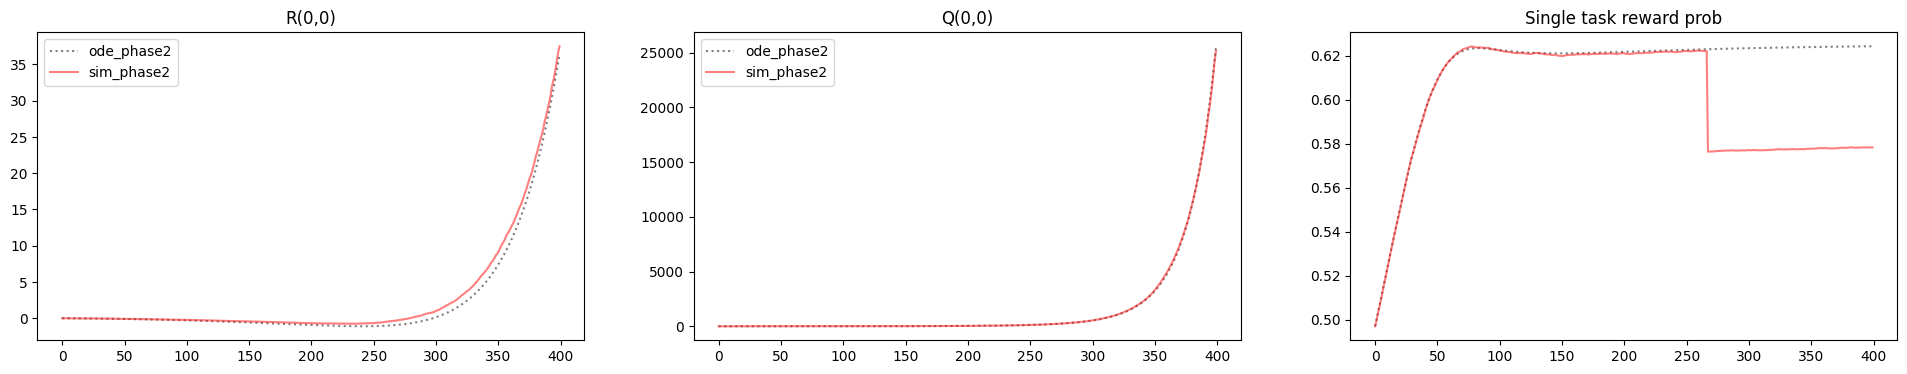

In [15]:
_ode = True
_simul = True
i,j = [0,0]
fig2 = plt.figure(figsize=(24, 4))
ax1 = plt.subplot(131)
if _ode:
    R2= np.mean(Rs_ode, axis = 0)
    ax1.plot(np.arange(len(R2)), R2, label = 'ode_phase2', alpha = 0.5, c = 'k', ls = 'dotted')
    
if _simul:
    R2_sim=np.mean(Rs_sim, axis = 0)
    ax1.plot(np.arange(len(R2_sim)), R2_sim, label = 'sim_phase2', alpha = 0.5, c = 'red')
    
ax1.set_title('R(0,0)')
plt.legend()
ax2 = plt.subplot(132)

if _ode:
    Q2= np.mean(Qs_ode, axis = 0)
    ax2.plot(np.arange(len(Q2)), Q2, label = 'ode_phase2', alpha = 0.5, c = 'k', ls = 'dotted')
    
if _simul:
    Q2_sim=np.mean(Qs_sim, axis = 0)
    ax2.plot(np.arange(len(Q2_sim)), Q2_sim, label = 'sim_phase2', alpha = 0.5, c = 'red')
    
ax2.set_title('Q(0,0)')
plt.legend()

ax3 = plt.subplot(133)

if _ode:
    Pt= np.mean(Pts_ode, axis = 0)
    ax3.plot(np.arange(len(Pt)), Pt, label = 'ode_phase2', alpha = 0.5, c = 'k', ls = 'dotted')
    
if _simul:
    Pt_sim=np.mean(Pts_sim, axis = 0)
    ax3.plot(np.arange(len(Pt_sim)), Pt_sim, label = 'sim_phase2', alpha = 0.5, c = 'red')
    ax3.set_title('Single task reward prob')

"""
ax4 = plt.subplot(154)
if _ode:
    Pt1=ode.history['phase1']['P_tilde']
    Pt2=ode.history['phase2']['P_tilde']
    ax4.plot(np.arange(len(Pt1)), Pt1, label = 'ode_phase1', alpha = 0.5, c = 'k', ls = 'dotted')
    ax4.plot(np.arange(len(Pt1), len(Pt1)+ len(Pt2)), Pt2, label = 'ode_phase2', alpha = 1, c = 'k', ls = 'dotted')
if _simul:
    Pt1_sim=base_solver.history['phase1']['P_tilde']
    Pt2_sim=base_solver.history['phase2']['P_tilde']
    ax4.plot(np.arange(len(Pt1_sim)), Pt1_sim, label = 'sim_phase1', alpha = 0.5, c = 'red', )
    ax4.plot(np.arange(len(Pt1_sim), len(Pt1_sim)+ len(Pt2_sim)), Pt2_sim, label = 'sim_phase2', alpha = 1, c = 'red')

ax4.set_title('Composed task reward prob')


ax5 = plt.subplot(155)
i=2
if _ode:
    V1=[k[i] for k in ode.history['phase1']['VS']]
    V2=[k[i] for k in ode.history['phase2']['VS']]
    ax5.plot(np.arange(len(V1)), V1, label = 'ode_phase1', alpha = 0.5, c = 'k', ls = 'dotted')
    ax5.plot(np.arange(len(V1), len(V1)+ len(V2)), V2, label = 'ode_phase2', alpha = 1, c = 'k', ls = 'dotted')

if _simul:
    V1_sim=[k[i] for k in base_solver.history['phase1']['VS']]
    V2_sim=[k[i] for k in base_solver.history['phase2']['VS']]
    ax5.plot(np.arange(len(V1_sim)), V1_sim, label = 'sim_phase1', alpha = 0.5, c = 'red', )
    ax5.plot(np.arange(len(V1_sim), len(V1_sim)+ len(V2_sim)), V2_sim, label = 'sim_phase2', alpha = 1, c = 'red')

ax5.set_title('VS')
"""

Text(0.5, 1.0, 'VS')

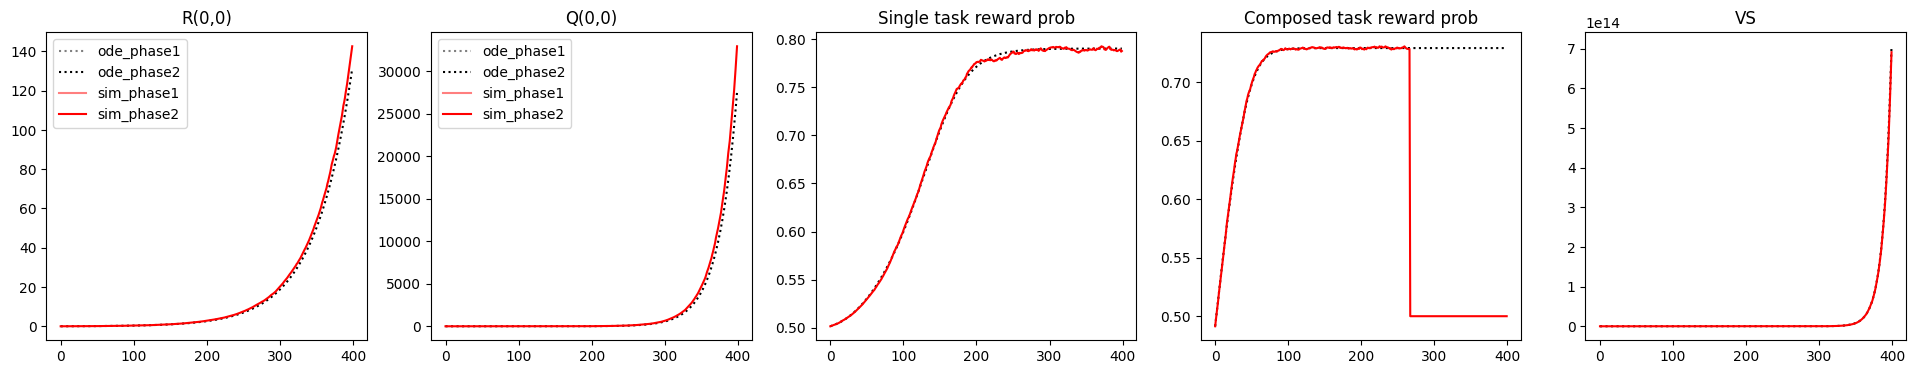

In [16]:
_ode = True
_simul = True
i,j = [0,0]
fig2 = plt.figure(figsize=(24, 4))
ax1 = plt.subplot(151)
if _ode:
    R1 = [k[i,j] for k in ode.history['phase1']['R']]
    R2=[k[i,j] for k in ode.history['phase2']['R']]
    ax1.plot(np.arange(len(R1)), R1, label = 'ode_phase1', alpha = 0.5, c = 'k', ls = 'dotted')
    ax1.plot(np.arange(len(R1), len(R1)+ len(R2)), R2, label = 'ode_phase2', alpha = 1, c = 'k', ls = 'dotted')
if _simul:
    R1_sim=[k[i,j] for k in base_solver.history['phase1']['R']]
    R2_sim=[k[i,j] for k in base_solver.history['phase2']['R']]
    ax1.plot(np.arange(len(R1_sim)), R1_sim, label = 'sim_phase1', alpha = 0.5, c = 'red')
    ax1.plot(np.arange(len(R1_sim), len(R1_sim)+ len(R2_sim)), R2_sim, label = 'sim_phase2', alpha = 1, c='red')

    
ax1.set_title('R(0,0)')
plt.legend()
ax2 = plt.subplot(152)

if _ode:
    Q1 = [k[i,j] for k in ode.history['phase1']['Q']]
    Q2=[k[i,j] for k in ode.history['phase2']['Q']]
    ax2.plot(np.arange(len(Q1)), Q1, label = 'ode_phase1', alpha = 0.5, c = 'k', ls = 'dotted')
    ax2.plot(np.arange(len(Q1), len(Q1)+ len(Q2)), Q2, label = 'ode_phase2', alpha = 1, c = 'k', ls = 'dotted')
if _simul:
    Q1_sim=[k[i,j] for k in base_solver.history['phase1']['Q']]
    Q2_sim=[k[i,j] for k in base_solver.history['phase2']['Q']]
    ax2.plot(np.arange(len(Q1_sim)), Q1_sim, label = 'sim_phase1', alpha = 0.5, c = 'red')
    ax2.plot(np.arange(len(Q1_sim), len(Q1_sim)+ len(Q2_sim)), Q2_sim, label = 'sim_phase2', alpha = 1, c='red')

ax2.set_title('Q(0,0)')
plt.legend()

ax3 = plt.subplot(153)
if _ode:
    P1=[p[0]for p in ode.history['phase1']['P']]
    P2=[p[0]for p in ode.history['phase2']['P']]
    ax3.plot(np.arange(len(P1)), P1, label = 'ode_phase1', alpha = 0.5, c = 'k', ls = 'dotted')
    ax3.plot(np.arange(len(P1), len(P1)+ len(P2)), P2, label = 'ode_phase2', alpha = 1, c = 'k', ls = 'dotted')
if _simul:
    P1_sim=[p[0]for p in base_solver.history['phase1']['P']]
    P2_sim=[p[0]for p in base_solver.history['phase2']['P']]
    ax3.plot(np.arange(len(P1_sim)), P1_sim, label = 'sim_phase1', alpha = 0.5, c = 'red', )
    ax3.plot(np.arange(len(P1_sim), len(P1_sim)+ len(P2_sim)), P2_sim, label = 'sim_phase2', alpha = 1, c = 'red')
ax3.set_title('Single task reward prob')


ax4 = plt.subplot(154)
if _ode:
    Pt1=ode.history['phase1']['P_tilde']
    Pt2=ode.history['phase2']['P_tilde']
    ax4.plot(np.arange(len(Pt1)), Pt1, label = 'ode_phase1', alpha = 0.5, c = 'k', ls = 'dotted')
    ax4.plot(np.arange(len(Pt1), len(Pt1)+ len(Pt2)), Pt2, label = 'ode_phase2', alpha = 1, c = 'k', ls = 'dotted')
if _simul:
    Pt1_sim=base_solver.history['phase1']['P_tilde']
    Pt2_sim=base_solver.history['phase2']['P_tilde']
    ax4.plot(np.arange(len(Pt1_sim)), Pt1_sim, label = 'sim_phase1', alpha = 0.5, c = 'red', )
    ax4.plot(np.arange(len(Pt1_sim), len(Pt1_sim)+ len(Pt2_sim)), Pt2_sim, label = 'sim_phase2', alpha = 1, c = 'red')

ax4.set_title('Composed task reward prob')


ax5 = plt.subplot(155)
i=2
if _ode:
    V1=[k[i] for k in ode.history['phase1']['VS']]
    V2=[k[i] for k in ode.history['phase2']['VS']]
    ax5.plot(np.arange(len(V1)), V1, label = 'ode_phase1', alpha = 0.5, c = 'k', ls = 'dotted')
    ax5.plot(np.arange(len(V1), len(V1)+ len(V2)), V2, label = 'ode_phase2', alpha = 1, c = 'k', ls = 'dotted')

if _simul:
    V1_sim=[k[i] for k in base_solver.history['phase1']['VS']]
    V2_sim=[k[i] for k in base_solver.history['phase2']['VS']]
    ax5.plot(np.arange(len(V1_sim)), V1_sim, label = 'sim_phase1', alpha = 0.5, c = 'red', )
    ax5.plot(np.arange(len(V1_sim), len(V1_sim)+ len(V2_sim)), V2_sim, label = 'sim_phase2', alpha = 1, c = 'red')

ax5.set_title('VS')


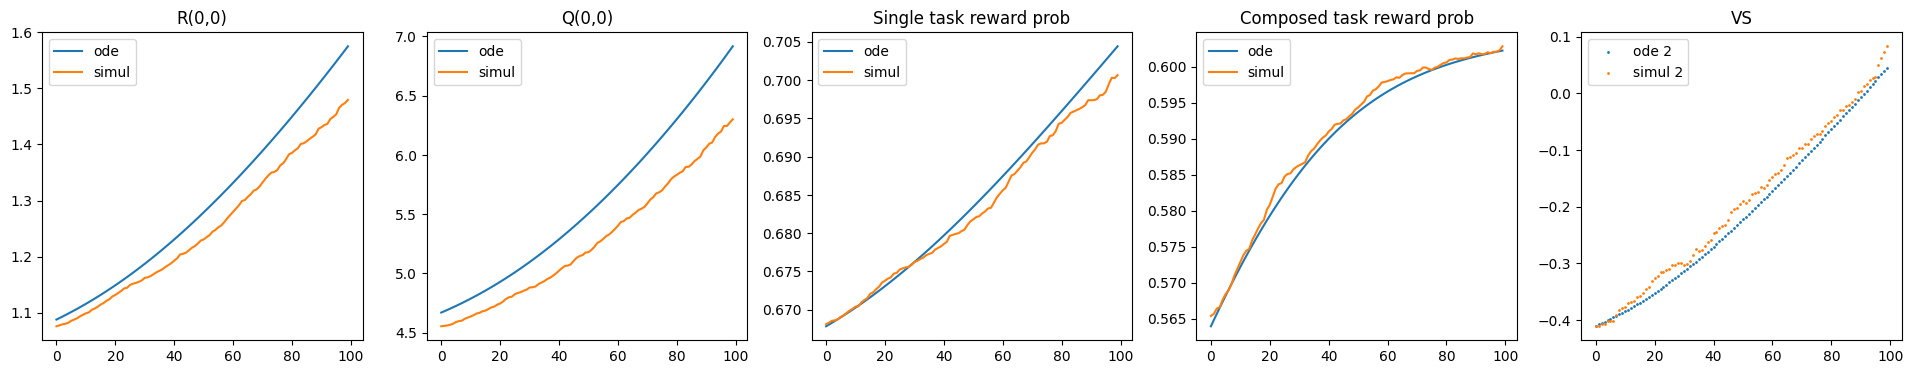

In [18]:
_ode = True
_simul = True
i,j = [0,0]
fig2 = plt.figure(figsize=(24, 4))
ax1 = plt.subplot(151)
if _ode:
    R=[k[i,j] for k in ode.history['phase2']['R']]
    ax1.plot(R, label = 'ode')
if _simul:
    RR=[k[i,j] for k in base_solver.history['phase2']['R']]

    ax1.plot(RR, label = 'simul')
    
ax1.set_title('R(0,0)')
plt.legend()
ax2 = plt.subplot(152)

if _ode:
    Q=[k[i,j] for k in ode.history['phase2']['Q']]
    #Qk=[k[i,j] for k in ode.history['Qk']]
    #Ql=[k[i,j] for k in ode.history['Ql']]
    #Qkl=[k[i,j] for k in ode.history['Qkl']]
    
    ax2.plot(Q, label = 'ode')
    #ax2.plot(Qk, label = 'ode k')
    #ax2.plot(Ql, label = 'ode l ')
    #ax2.plot(Qkl, label = 'ode kl')
if _simul:
    QQ=[k[i,j] for k in base_solver.history['phase2']['Q']]
    ax2.plot(QQ, label = 'simul')
ax2.set_title('Q(0,0)')
plt.legend()

ax3 = plt.subplot(153)
if _ode:
    P=ode.history['phase2']['P']
    ax3.plot([p[0] for p in P], label = 'ode')
if _simul:
    PP=base_solver.history['phase2']['P']
    ax3.plot([p[0] for p in PP], label = 'simul')
ax3.set_title('Single task reward prob')
plt.legend()

ax4 = plt.subplot(154)
if _ode:
    P=ode.history['phase2']['P_tilde']
    ax4.plot(P, label = 'ode')
if _simul:
    PP=base_solver.history['phase2']['P_tilde']
    ax4.plot(PP, label = 'simul')
ax4.set_title('Composed task reward prob')
plt.legend()

ax5 = plt.subplot(155)
i=2
if _ode:
    dv=[k[i] for k in ode.history['phase2']['VS']]
    ax5.scatter(np.arange(len(dv)), dv, label = f'ode {i}', s=1)
if _simul:
    dvv=[k[i] for k in base_solver.history['phase2']['VS']]
    ax5.scatter(np.arange(len(dvv)), dvv, label = f'simul {i}', s=1)


ax5.set_title('VS')
plt.legend()

In [17]:
base_solver.history['phase2']['VS'][0].shape

torch.Size([1, 4])

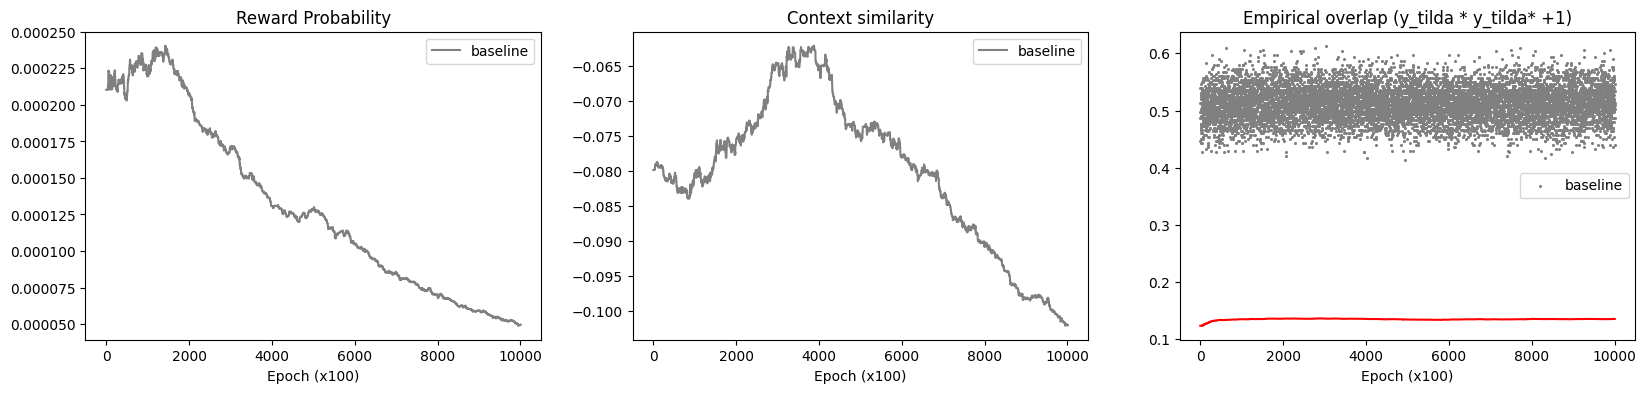

In [37]:
base = True
curriculum = False
fig = plt.figure(figsize=(20, 4))
ax1 = plt.subplot(131)
if curriculum:
    ax1.plot(curriculum_solver.history['phase1']['reward_rate'], label = 'pre-training phase1', c= 'r', alpha = 0.2)
    len_phase1 = len(curriculum_solver.history['phase1']['reward_rate'])
    len_phase2 = len(curriculum_solver.history['phase2']['reward_rate'])
    ax1.plot(np.arange(len_phase1, len_phase1+len_phase2),
             curriculum_solver.history['phase2']['reward_rate'], label = 'pre-training phase2', c= 'r')
if base:
    ax1.plot(base_solver.history['phase2']['reward_rate'], label = 'baseline', c= 'gray')
ax1.set_title('Reward Probability')
ax1.set_xlabel('Epoch (x100)')

plt.legend()
ax2 = plt.subplot(132)
if curriculum:
    ax2.plot(curriculum_solver.history['phase2']['context_similarity'], label = 'pre-training phase2', c = 'r')
if base:
    ax2.plot(base_solver.history['phase2']['context_similarity'], label = 'baseline', c= 'gray')
ax2.set_title('Context similarity')
ax2.set_xlabel('Epoch (x100)')
plt.legend()

ax3 = plt.subplot(133)

if curriculum:
    curriculum_empirical_overlap = curriculum_solver.history['phase2']['overlap']
    curriculum_P = curriculum_solver.history['phase2']['P']
    ax3.scatter(np.arange(len(curriculum_empirical_overlap)),curriculum_empirical_overlap, s= 1.5, c = 'r', label = 'pre-trianing phase2')
    ax3.plot(np.power(np.array(curriculum_P),3) +1,  c = 'r', )
if base:
    base_empirical_overlap = base_solver.history['phase2']['overlap']
    base_P = base_solver.history['phase2']['P']
    ax3.scatter(np.arange(len(base_empirical_overlap)),base_empirical_overlap, c= 'gray', label = 'baseline', s=1.5)
    ax3.plot(np.power(np.array(base_P),3), c= 'red', )

ax3.set_title('Empirical overlap (y_tilda * y_tilda* +1)')
ax3.set_xlabel('Epoch (x100)')
plt.legend()

In [23]:
samples= []
for i in range(100):
    x = dataloader.get_batch()['x']
    _, ys_tilde_sign_hat, _, ys_tilde_sign = base_solver._phase2_inference(x)
    samples.append((ys_tilde_sign_hat* ys_tilde_sign +1).mean().item())

In [24]:
samples

[2.0,
 0.6666666865348816,
 1.3333333730697632,
 0.6666666865348816,
 1.3333333730697632,
 1.3333333730697632,
 0.6666666865348816,
 1.3333333730697632,
 0.6666666865348816,
 1.3333333730697632,
 0.0,
 0.6666666865348816,
 1.3333333730697632,
 1.3333333730697632,
 2.0,
 0.6666666865348816,
 0.6666666865348816,
 2.0,
 2.0,
 1.3333333730697632,
 0.0,
 1.3333333730697632,
 0.6666666865348816,
 0.0,
 0.6666666865348816,
 0.6666666865348816,
 0.0,
 1.3333333730697632,
 2.0,
 0.6666666865348816,
 1.3333333730697632,
 1.3333333730697632,
 1.3333333730697632,
 1.3333333730697632,
 1.3333333730697632,
 0.6666666865348816,
 0.6666666865348816,
 1.3333333730697632,
 2.0,
 0.6666666865348816,
 2.0,
 0.6666666865348816,
 0.6666666865348816,
 0.0,
 0.0,
 1.3333333730697632,
 1.3333333730697632,
 0.6666666865348816,
 1.3333333730697632,
 1.3333333730697632,
 1.3333333730697632,
 0.6666666865348816,
 0.6666666865348816,
 1.3333333730697632,
 0.0,
 0.6666666865348816,
 2.0,
 1.3333333730697632,
 2.0,
 

In [22]:
base_empirical_overlap

[1.0733333545923234,
 1.0133333551883696,
 0.9266666865348816,
 0.9733333551883697,
 1.0000000244379044,
 1.0000000196695327,
 1.0333333563804628,
 0.9666666895151138,
 0.9866666889190674,
 1.0600000238418579,
 1.1000000268220902,
 1.0066666907072068,
 0.9800000202655792,
 1.0533333557844162,
 0.9800000220537186,
 1.020000021457672,
 1.0066666901111603,
 1.0066666895151137,
 1.0133333551883696,
 0.960000022649765,
 1.060000022649765,
 1.0133333563804627,
 0.8466666895151138,
 0.9333333539962768,
 1.0400000220537187,
 1.0133333575725556,
 0.993333352804184,
 1.0333333557844162,
 1.0000000208616258,
 1.013333356976509,
 1.1000000208616256,
 1.0000000220537186,
 0.9800000232458115,
 1.0533333563804625,
 1.0066666889190674,
 0.9133333557844162,
 1.0866666930913924,
 1.0000000244379044,
 0.9466666901111602,
 1.0133333563804627,
 1.0733333539962768,
 0.973333352804184,
 1.0733333545923234,
 1.1266666918992996,
 0.973333358168602,
 0.9933333575725556,
 1.080000022649765,
 0.9266666877269745,


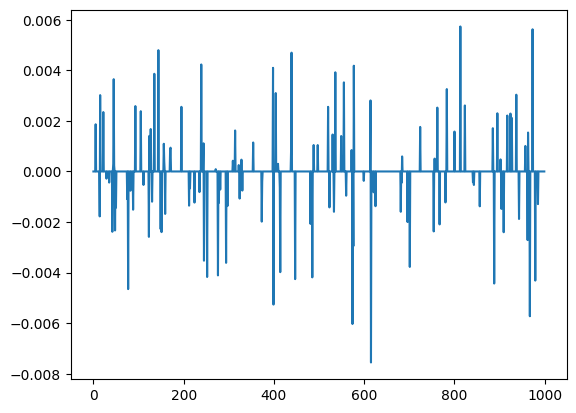

In [9]:

Q1=np.array([k[1,0] for k in base_solver.history['phase2']['Q']])
Q2=np.array([k[1,0] for k in base_solver.history['phase2']['Q']])
plt.plot(Q1[1:]-Q2[:-1])

In [29]:
dvv=[k[0].item() for k in base_solver.dv]

In [30]:
dvv

[-0.018091371282935143,
 -0.007992281578481197,
 -0.0002142446319339797,
 -0.03016391582787037,
 -0.03215823695063591,
 -0.006630501244217157,
 -0.01360038947314024,
 -0.02515581250190735,
 -0.0205030906945467,
 -0.03257043659687042,
 -0.028778793290257454,
 -0.02140030264854431,
 -0.024489765986800194,
 -0.028125831857323647,
 -0.013224801979959011,
 -0.045649826526641846,
 -0.027134699746966362,
 -0.004643208347260952,
 -0.05654069408774376,
 -0.010625764727592468,
 -0.00792646873742342,
 -0.026894599199295044,
 -0.032958850264549255,
 -0.015700969845056534,
 -0.004220565780997276,
 -0.010491777211427689,
 -0.009977634064853191,
 0.009291664697229862,
 0.007832614704966545,
 -0.01798682101070881,
 -0.021595275029540062,
 -0.024594279006123543,
 -0.039778754115104675,
 -0.03307825326919556,
 -0.031225154176354408,
 -0.009635558351874352,
 -0.020532546564936638,
 -0.019756540656089783,
 -0.018144024536013603,
 -0.002723218174651265,
 -0.005645085591822863,
 -0.028158968314528465,
 0.00